In [1]:
import matplotlib.pyplot as plt
from snsphd import viz
import numpy as np
Colors, swatches = viz.phd_style(jupyterStyle=True, grid=True)
import json
from snsphd.layout import bisect

In [2]:
with open("../data/comparison_200ns_dead_time.json", "r") as f:
    data_dead_time = json.load(f)

with open("../data/comparison_time_walk.json", "r") as f:
    data_correction = json.load(f)

In [3]:
class Parabola:
    def __init__(self, coeffs):
        self.coeffs = coeffs
    def __call__(self, x):
        x = np.array(x)
        return self.coeffs[0]*x**2 + self.coeffs[1]*x + self.coeffs[2]
    
    def inverse(self, y):
        a, b, c = self.coeffs
        x1 = (-b + np.sqrt(b**2 - 4*a*(c-y))) / (2*a)
        x2 = (-b - np.sqrt(b**2 - 4*a*(c-y))) / (2*a)
        return x1, x2
    

mu_from_power = Parabola([0.00099227, -0.00286844,  0.00231563])

In [4]:
def avg_std(ls):
    avg = np.average(ls)
    std = np.std(ls)
    return avg, std

class AvgStdGrower:
    def __init__(self):
        self.avg = []
        self.std = []

    def add(self, ls):
        avg, std = avg_std(ls)
        self.avg.append(avg)
        self.std.append(std)

    def to_array(self):
        self.avg = np.array(self.avg)
        self.std = np.array(self.std)


def data_to_arrays(ls):

    singles_1_d = AvgStdGrower()
    singles_2_d = AvgStdGrower()
    coinc_d = AvgStdGrower()
    amps = []
    for i, item in enumerate(ls):
        res = item["results"]
        amp = res[0]["results"]["expected_amps"]
        coinc = res[2]["coincidence rate"]
        singles_1 = res[2]["singles_1_rate"]
        singles_2 = res[2]["singels_2_rate"]

        # I made a mistake when I wrote the measurment script,
        # I divided by delta_t measured since the beginning of the integration
        # rather than the beginning of each iteration. (each integration step is made from from about 40 to 20 iterations)
        # This is an approximate fix, assuming the delta_time of each iteration is constant. 
        singles_1_t = [rate*(i+1) for i, rate in enumerate(singles_1)]
        singles_2_t = [rate*(i+1) for i, rate in enumerate(singles_2)]
        coinc_t = [rate*(i+1) for i, rate in enumerate(coinc)]

        singles_1_d.add(singles_1_t)
        singles_2_d.add(singles_2_t)
        coinc_d.add(coinc_t)
        amps.append(amp)

    singles_1_d.to_array()
    singles_2_d.to_array()
    coinc_d.to_array()

    return singles_1_d, singles_2_d, coinc_d, amps

        

singles_a, singles_b, coinc, amps = data_to_arrays(data_dead_time["results"])
singles_a_j, singles_b_j, coinc_j, amps_j = data_to_arrays(data_correction["results"])



['..', 'figs', 'time_walk_comparison']
../figs/
pickleable


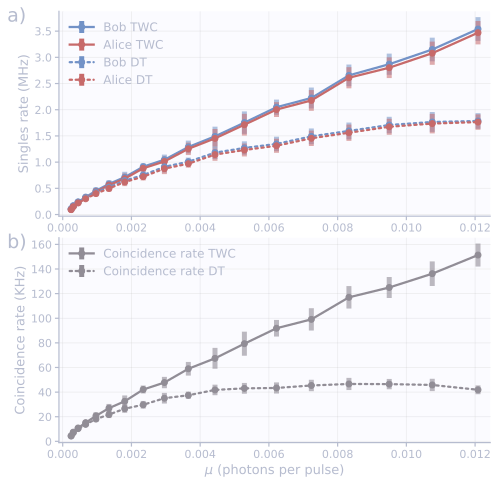

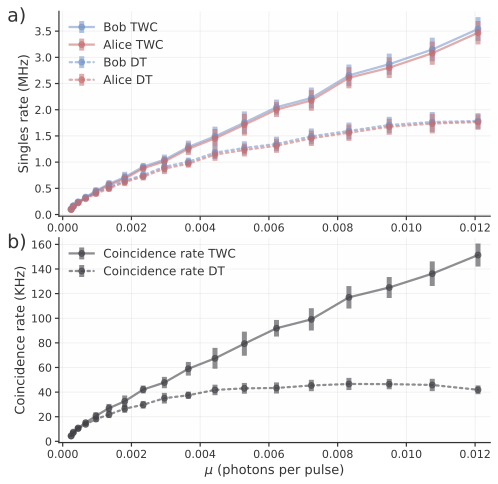

In [10]:
bottom, top = bisect([0, 0, 1, 1], direction="horiz", offset=0.5, spacing=0.05)
fig = plt.figure(figsize=(6, 6))
top_ax = fig.add_axes(top)
bottom_ax = fig.add_axes(bottom)

line_style = "-"
markersize = 6
marker = "o"
########### top
top_ax.errorbar(
    mu_from_power(amps),
    singles_b_j.avg / 1e6,
    yerr=singles_b_j.std / 1e6,
    elinewidth=5,
    color=Colors["blue"],
    alpha=0.55,
    marker=marker,
    linestyle=line_style,
    markersize=markersize,
    label="Bob TWC",
    capsize=0
)

top_ax.errorbar(
    mu_from_power(amps),
    singles_a_j.avg / 1e6,
    yerr=singles_a_j.std / 1e6,
    elinewidth=5,
    color=Colors["red"],
    alpha=0.55,
    marker=marker,
    linestyle="-",
    markersize=markersize,
    label="Alice TWC",
    capsize=0
)

top_ax.errorbar(
    mu_from_power(amps),
    singles_b.avg / 1e6,
    yerr=singles_b.std / 1e6,
    elinewidth=5,
    color=Colors["blue"],
    alpha=0.55,
    marker=marker,
    linestyle=":",
    markersize=markersize,
    label="Bob DT",
    capsize=0
)

top_ax.errorbar(
    mu_from_power(amps),
    singles_a.avg / 1e6,
    yerr=singles_a.std / 1e6,
    elinewidth=5,
    color=Colors["red"],
    alpha=0.55,
    marker=marker,
    linestyle=":",
    markersize=markersize,
    label="Alice DT",
    capsize=0
)

########### bottom

bottom_ax.errorbar(
    mu_from_power(amps),
    coinc_j.avg/1e3,
    yerr=coinc_j.std/1e3,
    elinewidth=5,
    color=Colors["black"],
    alpha=0.6,
    marker=marker,
    linestyle="-",
    markersize=markersize,
    label="Coincidence rate TWC",
    capsize=0
)
bottom_ax.errorbar(
    mu_from_power(amps),
    coinc.avg/1e3,
    yerr=coinc.std/1e3,
    elinewidth=5,
    color=Colors["black"],
    alpha=0.6,
    marker=marker,
    linestyle=":",
    markersize=markersize,
    label="Coincidence rate DT",
    capsize=0
)

top_ax.legend(loc="upper left", fontsize=12, frameon=False)
bottom_ax.legend(loc="upper left", fontsize=12, frameon=False)


top_ax.set_ylabel("Singles rate (MHz)")
bottom_ax.set_ylabel("Coincidence rate (KHz)")
bottom_ax.set_xlabel(r"$\mu$ (photons per pulse)")

top_ax.text(-0.12, 1.02, "a)", transform=top_ax.transAxes, fontsize=19, va="top")
bottom_ax.text(-0.12, 1.02, "b)", transform=bottom_ax.transAxes, fontsize=19, va="top")

viz.save_light_dark_all(fig, name="../figs/time_walk_comparison")

In [6]:
print("time walk correction gives a ", round(max(coinc_j.avg)/max(coinc.avg),1)*100, "% increase in the coincidence rate")

time walk correction gives a  320.0 % increase in the coincidence rate


In [ ]:
max(singles_b_j.avg)/max(singes_b.avg)